# Parameter sweep for LBI predictor

Load flu tip attributes and final clade frequencies and then calculate the error of an exponential growth model based on just the LBI predictor across a range of predictor coefficients. The goal is to determine the shape of the error function that is exposed to scipy's optimization machinery.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

plt.style.use("huddlej")

In [2]:
pwd

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses'

In [3]:
sys.path.insert(0, "../src")

In [4]:
from fit_model import ExponentialGrowthModel
from forecast.metrics import mean_absolute_error, sum_of_squared_errors, negative_information_gain, add_pseudocounts_to_frequencies

## Load data

Define the range of possible coefficient values to explore.

In [5]:
coefficients = np.linspace(-3, 3, 21)

In [6]:
delta_time = 1.0
l1_lambda = 0.0

In [7]:
last_timepoint = pd.to_datetime("2016-10-01")

In [8]:
# Load tip attributes.
X = pd.read_csv(
    "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/standardized_tip_attributes.tsv",
    sep="\t",
    parse_dates=["timepoint"]
)

In [9]:
X = X.loc[:, ["strain", "clade_membership", "timepoint", "cTiterSub_x", "lbi", "ep", "ep_x", "ne", "delta_frequency", "frequency"]].copy()

In [10]:
X = X[X["timepoint"] <= last_timepoint]

In [11]:
X.head()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ep_x,ne,delta_frequency,frequency
0,A/BacGiang/BG003/2004,3a81d99,2004-10-01,NaN,-0.947616,10,-3.021977,6,-1.093891,0.001207
1,A/California/7/2004,44f9b1f,2004-10-01,-6.794363,1.584951,14,-2.273476,7,0.155149,0.013619
2,A/California/NHRC0002/2003,bee4aad,2004-10-01,NaN,0.142304,10,-2.995527,6,-0.390112,0.000005
3,A/Canterbury/100/2004,7aa732d,2004-10-01,-6.794363,1.771209,11,-2.814454,7,2.153910,0.014974
4,A/Canterbury/20/2004,7aa732d,2004-10-01,-6.794363,2.178898,11,-2.814454,7,2.153910,0.018538


In [12]:
X.shape

(5822, 10)

In [13]:
# Load final clade tip frequencies.
final_clade_frequencies = pd.read_csv(
    "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/final_clade_frequencies.tsv",
    sep="\t",
    parse_dates=["initial_timepoint", "final_timepoint"]
)

In [14]:
final_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2004-10-01,3a81d99,2005-10-01,A/Hanoi/ISBM16/2005,0.006537
1,2004-10-01,44f9b1f,2005-10-01,NaN,0.000000
2,2004-10-01,bee4aad,2005-10-01,NaN,0.000000
3,2004-10-01,7aa732d,2005-10-01,A/Auckland/616/2005,0.008753
4,2004-10-01,7aa732d,2005-10-01,A/Auckland/617/2005,0.008971


In [15]:
y = final_clade_frequencies.groupby([
    "initial_timepoint",
    "clade_membership"
])["frequency"].sum().reset_index()

y = y.rename(
    columns={"initial_timepoint": "timepoint"}
)

y = y[y["timepoint"] <= last_timepoint]

In [16]:
y.head()

,timepoint,clade_membership,frequency
0,2004-10-01,089c686,0.0
1,2004-10-01,094757b,0.0
2,2004-10-01,1523083,0.0
3,2004-10-01,1cfb9ff,0.0
4,2004-10-01,1dcd826,0.0


In [17]:
y.groupby("timepoint")["frequency"].sum()

timepoint
2004-10-01    0.999997
2005-04-01    0.999994
2005-10-01    0.999997
2006-04-01    0.999971
2006-10-01    0.999996
2007-04-01    1.000002
2007-10-01    1.000000
2008-04-01    1.000001
2008-10-01    1.000008
2009-04-01    0.999995
2009-10-01    1.000002
2010-04-01    0.996972
2010-10-01    0.991871
2011-04-01    0.991825
2011-10-01    0.989569
2012-04-01    0.995671
2012-10-01    0.999300
2013-04-01    1.000003
2013-10-01    0.999999
2014-04-01    0.997955
2014-10-01    0.996891
2015-04-01    0.000000
2015-10-01    0.000000
Name: frequency, dtype: float64

## Inspect LBI model

In [ ]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

Calculate error for an LBI model across all coefficients.

In [ ]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

In [ ]:
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("SSE")

In [ ]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("MAE")

## Inspect cTiterSub model

In [ ]:
predictors = ["cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [ ]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

In [ ]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer cross-immunity model coefficient")
plt.ylabel("SSE")

In [ ]:
predictors = ["cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer cross-immunity model coefficient")
plt.ylabel("MAE")

## Inspect epitope count model

In [ ]:
predictors = ["ep"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [ ]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

In [ ]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("SSE")

In [ ]:
predictors = ["ep"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("MAE")

## Inspect epitope cross-immunity model

In [ ]:
predictors = ["ep_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity model coefficient")
plt.ylabel("SSE")

In [ ]:
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity model coefficient")
plt.ylabel("MAE")

## Inspect delta frequency model

In [ ]:
predictors = ["delta_frequency"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

In [ ]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

In [ ]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Delta frequency model coefficient")
plt.ylabel("MAE")

## Inspect two-parameter models

In [ ]:
predictors = ["lbi", "cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [ ]:
len(coefficients)

In [ ]:
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
    
    errors_by_first_coefficient[coefficient_i] = errors

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("SSE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

In [ ]:
predictors = ["lbi", "cTiterSub_x"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

records = []
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
        records.append({
            "lbi": coefficient_i,
            "cTiterSub": coefficient_j,
            "error": error
        })
    
    errors_by_first_coefficient[coefficient_i] = errors

In [ ]:
records_df = pd.DataFrame(records)
records_df.sort_values("error").head()

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("MAE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

## Minimize negative information gain

Add pseudocounts to current and future tip frequencies.

In [18]:
pseudocount = 1e-6
X_with_pseudocounts = add_pseudocounts_to_frequencies(X, pseudocount)
final_clade_frequencies_with_pseudocounts = add_pseudocounts_to_frequencies(
    final_clade_frequencies,
    pseudocount,
    timepoint_column="initial_timepoint"
)

In [19]:
y_with_pseudocounts = final_clade_frequencies_with_pseudocounts.groupby([
    "initial_timepoint",
    "clade_membership"
])["frequency"].sum().reset_index()

y_with_pseudocounts = y_with_pseudocounts.rename(
    columns={"initial_timepoint": "timepoint"}
)

#y_with_pseudocounts = y_with_pseudocounts[y_with_pseudocounts["timepoint"] <= last_timepoint]

In [20]:
X_with_pseudocounts.head()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ep_x,ne,delta_frequency,frequency
0,A/BacGiang/BG003/2004,3a81d99,2004-10-01,NaN,-0.947616,10,-3.021977,6,-1.093891,0.001207
1,A/Hanoi/HN30130/2004,3a81d99,2004-10-01,NaN,-0.918210,10,-3.021977,6,-1.093891,0.000557
2,A/Hanoi/HN30135/2004,3a81d99,2004-10-01,NaN,-0.923689,10,-3.021977,6,-1.093891,0.000646
3,A/California/7/2004,44f9b1f,2004-10-01,-6.794363,1.584951,14,-2.273476,7,0.155149,0.013619
4,A/California/NHRC0002/2003,bee4aad,2004-10-01,NaN,0.142304,10,-2.995527,6,-0.390112,0.000006


In [21]:
final_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2004-10-01,3a81d99,2005-10-01,A/Hanoi/ISBM16/2005,0.006537
1,2004-10-01,44f9b1f,2005-10-01,NaN,0.000000
2,2004-10-01,bee4aad,2005-10-01,NaN,0.000000
3,2004-10-01,7aa732d,2005-10-01,A/Auckland/616/2005,0.008753
4,2004-10-01,7aa732d,2005-10-01,A/Auckland/617/2005,0.008971


In [22]:
final_clade_frequencies_with_pseudocounts.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2004-10-01,3a81d99,2005-10-01,A/Hanoi/ISBM16/2005,6.537595e-03
1,2004-10-01,44f9b1f,2005-10-01,NaN,9.999380e-07
2,2004-10-01,bee4aad,2005-10-01,NaN,9.999380e-07
3,2004-10-01,7aa732d,2005-10-01,A/Auckland/616/2005,8.752470e-03
4,2004-10-01,7aa732d,2005-10-01,A/Auckland/617/2005,8.970456e-03


In [23]:
y_with_pseudocounts.head()

,timepoint,clade_membership,frequency
0,2004-10-01,089c686,9.999380e-07
1,2004-10-01,094757b,9.999380e-07
2,2004-10-01,1523083,9.999380e-07
3,2004-10-01,1cfb9ff,9.999380e-07
4,2004-10-01,1dcd826,9.999380e-07


Training error for coefficients [-3.0]: 62.07117046072003
Training error for coefficients [-2.7]: 54.349008019085026
Training error for coefficients [-2.4]: 46.77811222596032
Training error for coefficients [-2.1]: 39.3978696216496
Training error for coefficients [-1.8]: 32.2621146765771
Training error for coefficients [-1.5]: 25.443049887431897
Training error for coefficients [-1.2000000000000002]: 19.03399749254337
Training error for coefficients [-0.8999999999999999]: 13.14948121946783
Training error for coefficients [-0.6000000000000001]: 7.921631346442259
Training error for coefficients [-0.30000000000000027]: 3.4923203905983744
Training error for coefficients [0.0]: 5.735060732370406e-15
Training error for coefficients [0.2999999999999998]: -2.4385900596820047
Training error for coefficients [0.5999999999999996]: -3.7475112185312054
Training error for coefficients [0.8999999999999999]: -3.9057992667363868
Training error for coefficients [1.2000000000000002]: -2.953407563545137
Tr

Text(0,0.5,'Negative information gain')

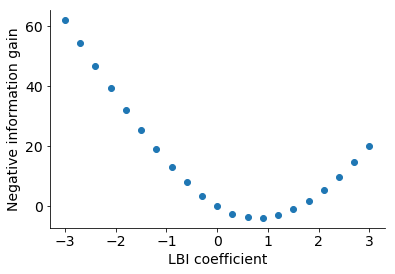

In [24]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X_with_pseudocounts, y_with_pseudocounts)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("Negative information gain")

Training error for coefficients [-3.0]: 22.93464487042579
Training error for coefficients [-2.7]: 18.756974453399803
Training error for coefficients [-2.4]: 14.94930976756871
Training error for coefficients [-2.1]: 11.5359901880372
Training error for coefficients [-1.8]: 8.541422123862949
Training error for coefficients [-1.5]: 5.98544400388202
Training error for coefficients [-1.2000000000000002]: 3.880703377247434
Training error for coefficients [-0.8999999999999999]: 2.2324913037716927
Training error for coefficients [-0.6000000000000001]: 1.0398139396020427
Training error for coefficients [-0.30000000000000027]: 0.2972881456632282
Training error for coefficients [0.0]: 5.735060732370406e-15
Training error for coefficients [0.2999999999999998]: 0.15762894526401489
Training error for coefficients [0.5999999999999996]: 0.8371178527864935
Training error for coefficients [0.8999999999999999]: 2.270169798714513
Training error for coefficients [1.2000000000000002]: 4.9098722684955245
Trai

Text(0,0.5,'Negative information gain')

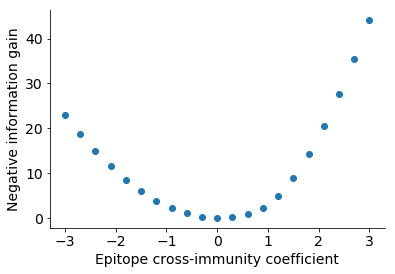

In [25]:
predictors = ["ep_x"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X_with_pseudocounts, y_with_pseudocounts)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity coefficient")
plt.ylabel("Negative information gain")

Training error for coefficients [-3.0]: 22.883149176893195
Training error for coefficients [-2.7]: 18.717033844760582
Training error for coefficients [-2.4]: 14.919242109862934
Training error for coefficients [-2.1]: 11.51426037857541
Training error for coefficients [-1.8]: 8.526586278840888
Training error for coefficients [-1.5]: 5.976121838959449
Training error for coefficients [-1.2000000000000002]: 3.8755767229420988
Training error for coefficients [-0.8999999999999999]: 2.2303139845116005
Training error for coefficients [-0.6000000000000001]: 1.0394203510838547
Training error for coefficients [-0.30000000000000027]: 0.29759487212222635
Training error for coefficients [0.0]: -3.8634528869302445e-06
Training error for coefficients [0.2999999999999998]: 0.15633802640352773
Training error for coefficients [0.5999999999999996]: 0.8334669423994341
Training error for coefficients [0.8999999999999999]: 2.2626016506512605
Training error for coefficients [1.2000000000000002]: 4.895756981366

Text(0,0.5,'Negative information gain')

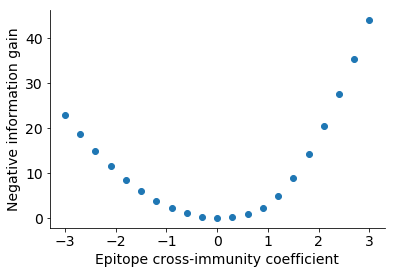

In [26]:
predictors = ["ep_x"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity coefficient")
plt.ylabel("Negative information gain")

In [27]:
predictors = ["lbi", "ep_x"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

records = []
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X_with_pseudocounts, y_with_pseudocounts)
        errors.append(error)
        records.append({
            "lbi": coefficient_i,
            "ep_x": coefficient_j,
            "error": error
        })
    
    errors_by_first_coefficient[coefficient_i] = errors

Training error for coefficients [-3.0, -3.0]: 100.20858034238022
Training error for coefficients [-3.0, -2.7]: 94.88115178353684
Training error for coefficients [-3.0, -2.4]: 89.83308343913856
Training error for coefficients [-3.0, -2.1]: 85.07415713993974
Training error for coefficients [-3.0, -1.8]: 80.62085578658875
Training error for coefficients [-3.0, -1.5]: 76.49638622804389
Training error for coefficients [-3.0, -1.2000000000000002]: 72.73071704063906
Training error for coefficients [-3.0, -0.8999999999999999]: 69.36067166021121
Training error for coefficients [-3.0, -0.6000000000000001]: 66.4288979421243
Training error for coefficients [-3.0, -0.30000000000000027]: 63.98117046735106
Training error for coefficients [-3.0, 0.0]: 62.07117046072003
Training error for coefficients [-3.0, 0.2999999999999998]: 60.8107520246768
Training error for coefficients [-3.0, 0.5999999999999996]: 60.53060606933494
Training error for coefficients [-3.0, 0.8999999999999999]: 61.853781941650865
Tr

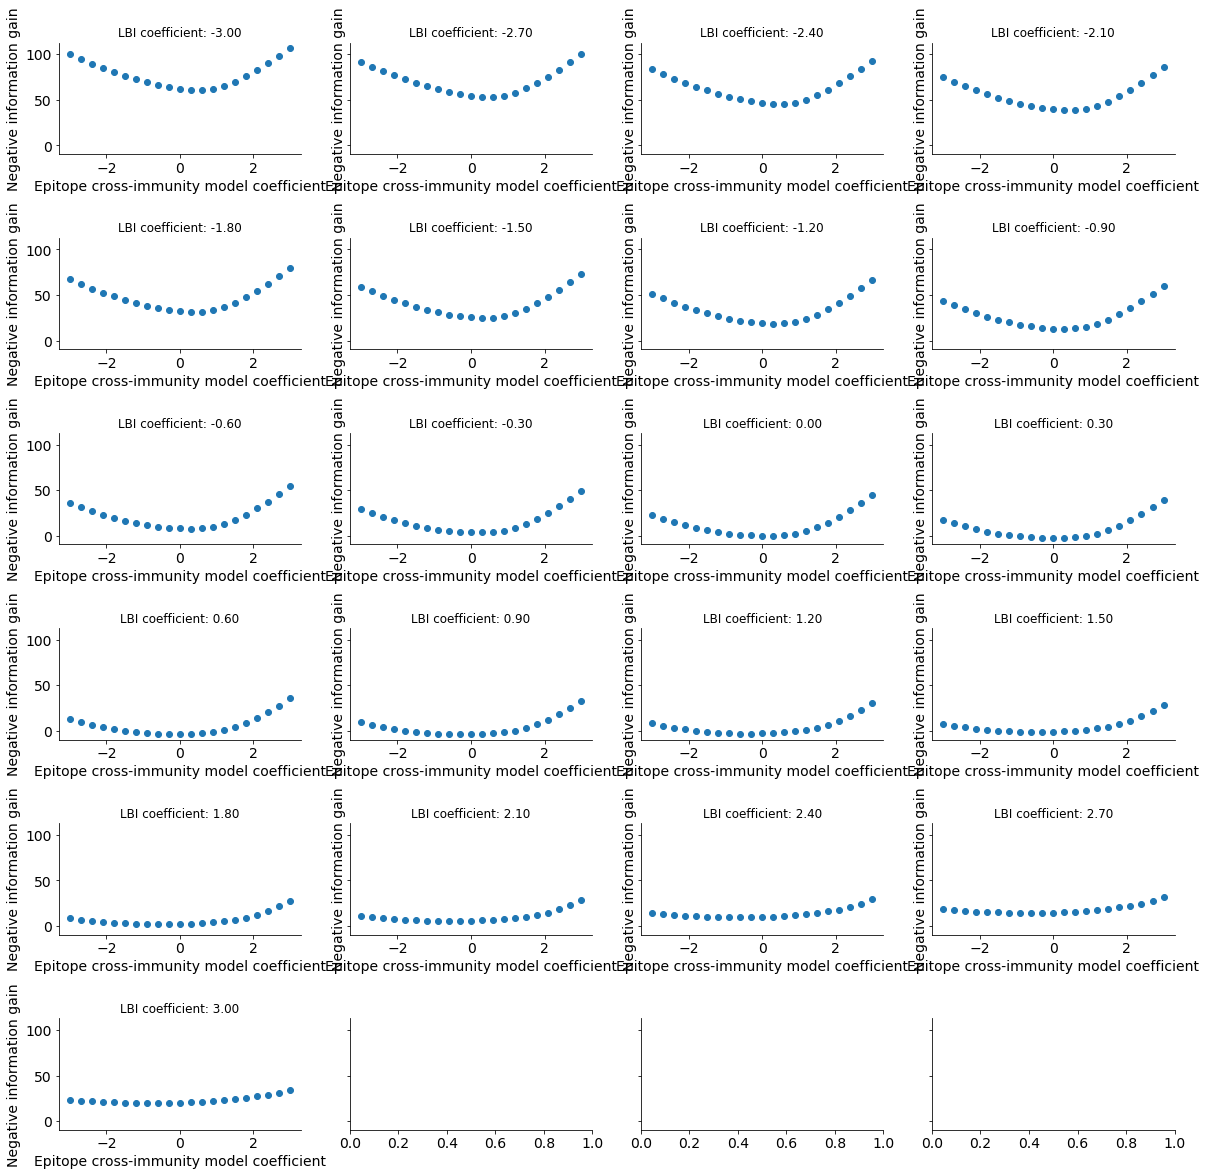

In [28]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Epitope cross-immunity model coefficient")
    ax.set_ylabel("Negative information gain")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

In [29]:
records_df = pd.DataFrame(records)
records_df.sort_values("error").head()

,ep_x,error,lbi
282,-0.3,-4.017556,0.9
283,0.0,-3.905799,0.9
281,-0.6,-3.821338,0.9
261,-0.3,-3.761840,0.6
262,0.0,-3.747511,0.6
